# Waves simulation Notebook 8

In this notebook we will refine the work done in Notebook 7, in particular we will cover the following tasks:
* Presenting an implementation of the 2D acoustic wave equation 
* Understanding the concepts of stability (Courant criterion)
* Exploration of numerical dispersion and numerical grid anisotropy
* Changing the earth model and exploring some effects of structural heterogeneities (e.g., fault zones)

Our aim in this notebook is to accurately simulate wave propagation in a fault zone (an earthquake that happens at depth) using the finite-difference method for a 2D acoustic wave equation with full reflective boundary ($p=0$ at the boundary).

## Numerical simulations

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Below is the 2D acoustic simulation code:

In [2]:
# Simple finite difference solver 
# Acoustic wave equation  p_tt = c^2 p_xx + src
# 2-D regular grid

nx = 200      # grid points in x - 500
nz = 200      # grid points in z - 500
nt = 1000     # number of time steps
dx = 10.0     # grid increment in x - 1
dt = 0.001    # Time step
c0 = 3000.0   # velocity (can be an array) - 580
isx = nx // 2 # source index x - 250
isz = nz // 2 # source index z - 250
ist = 100     # shifting of source time function
f0 = 50.0     # dominant frequency of source (Hz)
isnap = 10    # snapshot frequency
T = 1.0 / f0  # dominant period
nop = 5       # length of operator

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"
model_type = "fault_zone"

# Receiver locations
irx = np.array([60, 80, 100, 120, 140])
irz = np.array([5, 5, 5, 5, 5])
seis = np.zeros((len(irx), nt))

# Initialize pressure at different time steps and the second
# derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))


In [3]:
# Initialize velocity model (the fun bit!)
c = np.zeros((nz, nx))

if model_type == "homogeneous":
    c += c0
elif model_type == "fault_zone":
    c += c0
    c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8    
elif model_type == "surface_low_velocity_zone":
    c += c0
    c[1:10,:] *= 0.8
elif model_type == "random":
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    c += c0 * (1 + r)   
elif model_type == "topography":
    c += c0
    c[0 : 10, 10 : 50] = 0                         
    c[0 : 10, 105 : 115] = 0                       
    c[0 : 30, 145 : 170] = 0
    c[10 : 40, 20 : 40]  = 0
    c[0 : 15, 50 : 105] *= 0.8    
elif model_type == "slab":
    c += c0
    c[110 : 125, 0 : 125] = 1.4 * c0
    for i in range(110, 180):
        c[i , i-5 : i + 15 ] = 1.4 * c0
else:
    raise NotImplementedError
    
cmax = c.max()

In [4]:
# Source time function Gaussian, nt + 1 as we loose the last one by diff
src = np.empty(nt + 1)
for it in range(nt):
    src[it] = np.exp(-1.0 / T ** 2 * ((it - ist) * dt) ** 2)
# Take the first derivative
src = np.diff(src) / dt
src[nt - 1] = 0

<IPython.core.display.Javascript object>


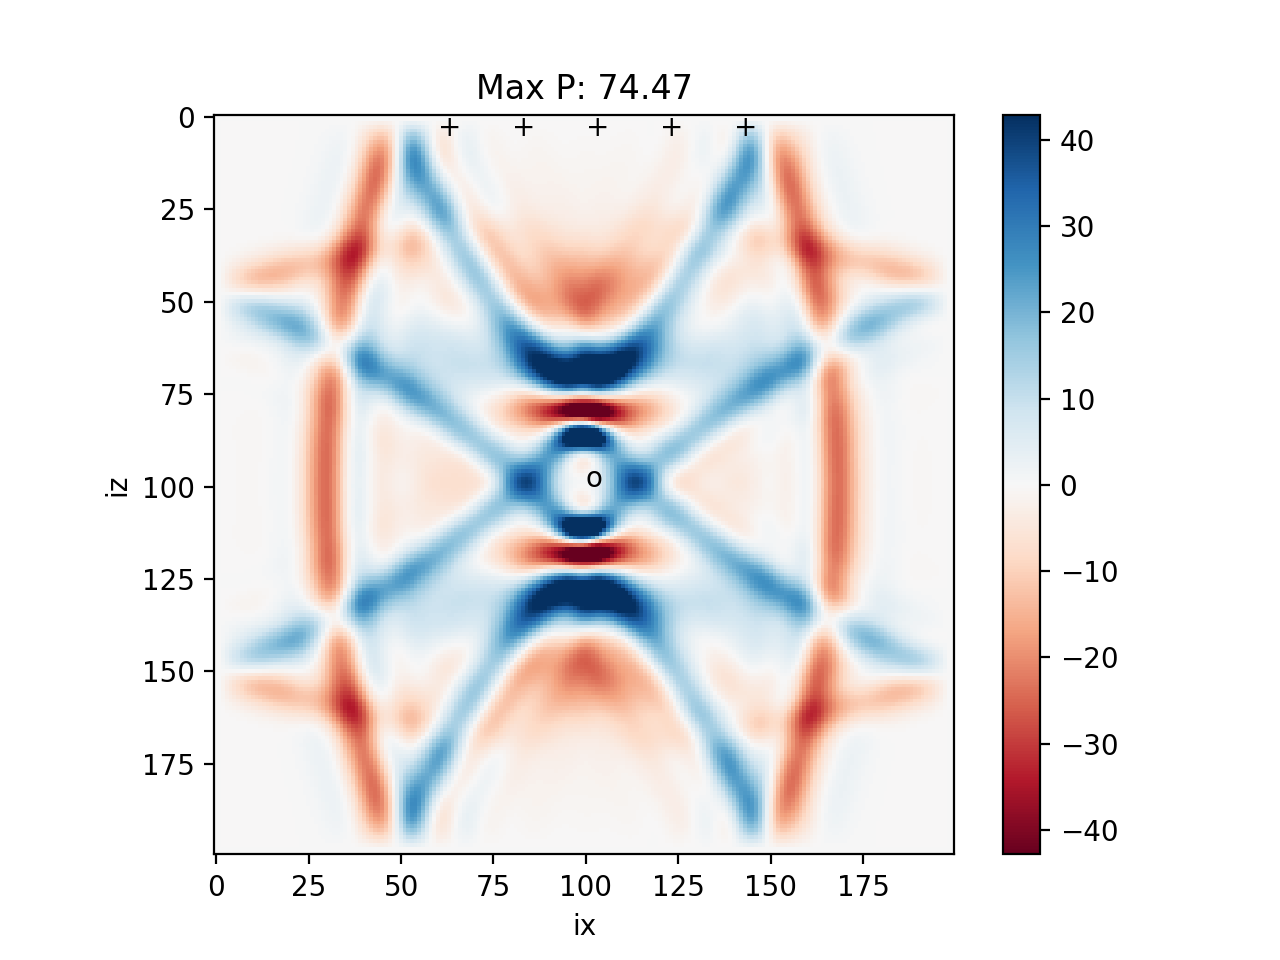

Courant Criterion eps :
0.3


In [5]:
# Plot preparation

v = max([np.abs(src.min()), np.abs(src.max())])
# Initialize animated plot
image = plt.imshow(pnew, interpolation='nearest', animated=True,
                   vmin=-v, vmax=+v, cmap=plt.cm.RdBu)


# Plot the receivers
for x, z in zip(irx, irz):
    plt.text(x, z, '+')

plt.text(isx, isz, 'o')
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')


plt.ion()
#plt.show(block=False)

# required for seismograms
ir = np.arange(len(irx))

# Output Courant criterion
print("Courant Criterion eps :")
print(cmax*dt/dx)

In [6]:
# Time extrapolation
for it in range(nt):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(1, nx - 1):
            pzz[:, i] = p[:, i + 1] - 2 * p[:, i] + p[:, i - 1]
        for j in range(1, nz - 1):
            pxx[j, :] = p[j - 1, :] - 2 * p[j, :] + p[j + 1, :]

    if nop==5:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(2, nx - 2):
            pzz[:, i] = -1./12*p[:,i+2]+4./3*p[:,i+1]-5./2*p[:,i]+4./3*p[:,i-1]-1./12*p[:,i-2]
        for j in range(2, nz - 2):
            pxx[j, :] = -1./12*p[j+2,:]+4./3*p[j+1,:]-5./2*p[j,:]+4./3*p[j-1,:]-1./12*p[j-2,:]
                    
            
    pxx /= dx ** 2
    pzz /= dx ** 2

    # Time extrapolation
    pnew = 2 * p - pold + dt ** 2 * c ** 2 * (pxx + pzz)
    # Add source term at isx, isz
    pnew[isz, isx] = pnew[isz, isx] + src[it]

    # Plot every isnap-th iteration
    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        
        plt.title("Max P: %.2f" % p.max())
        image.set_data(pnew)
        plt.gcf().canvas.draw()

    pold, p = p, pnew

    # Save seismograms
    seis[ir, it] = p[irz[ir], irx[ir]]

The cell below allows to plot source time function, seismic velocites, and the resulting seismograms in windows inside the notebook. Remember to rerun after each simulation.

<IPython.core.display.Javascript object>


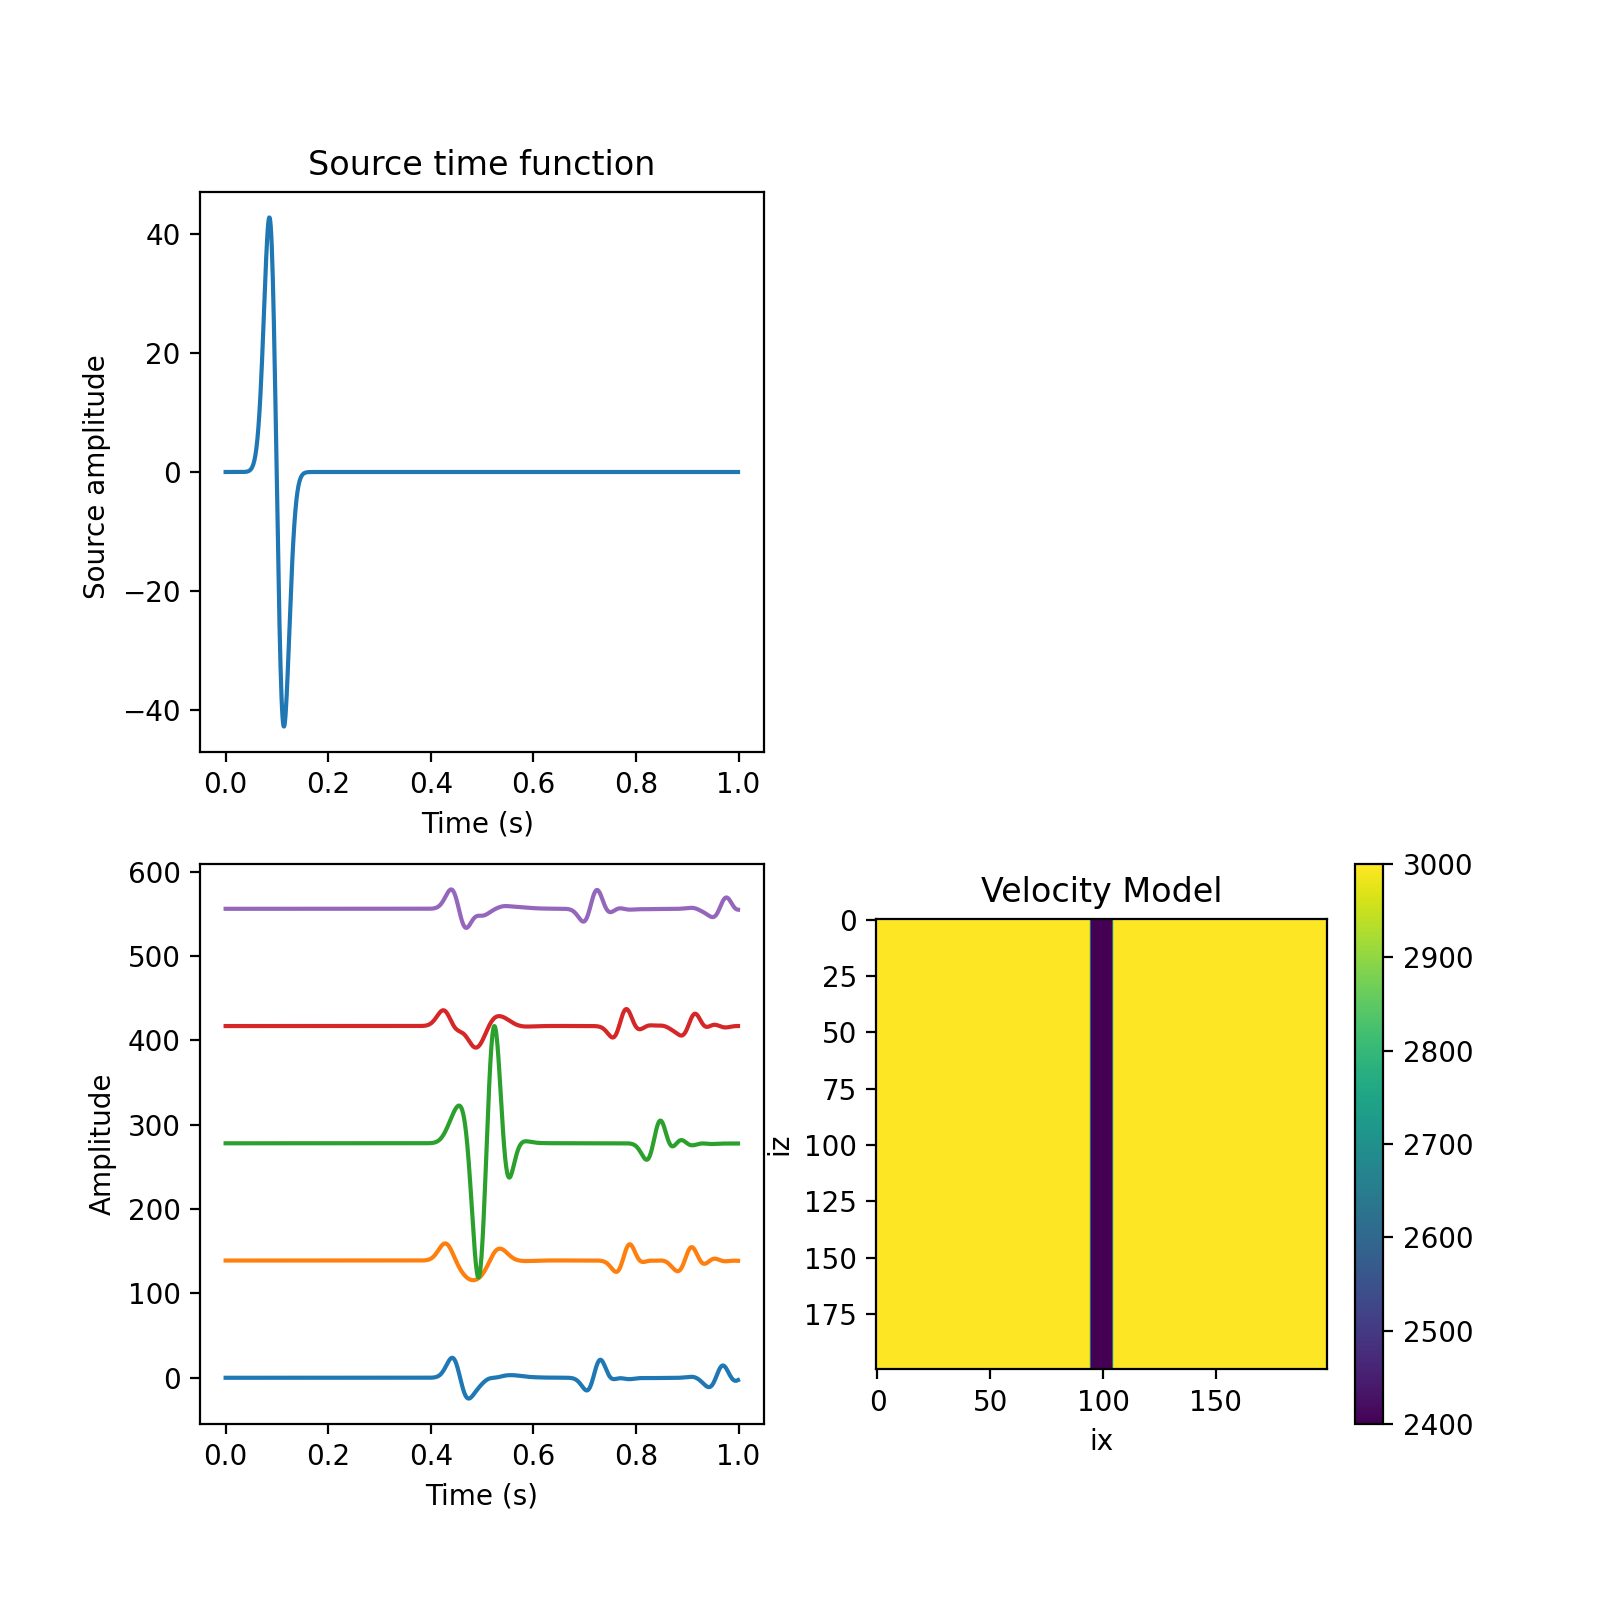

In [7]:
# Plot the source time function and the seismograms 

plt.ioff()
plt.figure(figsize=(8, 8))

plt.subplot(221)
time = np.arange(nt) * dt
plt.plot(time, src)
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

#plt.subplot(222)
#ymax = seis.ravel().max()  
#for ir in range(len(seis)):
#    plt.plot(time, seis[ir, :] + ymax * ir)
#    plt.xlabel('Time (s)')
#    plt.ylabel('Amplitude')

plt.subplot(223)
ymax = seis.ravel().max()
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.subplot(224)
# The velocity model is influenced by the Earth model above
plt.title('Velocity Model')
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
plt.colorbar()

plt.show()

## Conclusions
- To be sure about the results obtained we will need to carry out some convergence test